In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import shutil
import pandas as pd
import seaborn as sns
import torchvision
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from torchvision.io import read_image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms

# Exploratory Data Analysis

In [3]:
data = pd.read_csv('list_attr_celeba.txt',delim_whitespace=True,skiprows=1)
data.shape

(202599, 40)

In [4]:
data['Male'].value_counts()

-1    118165
 1     84434
Name: Male, dtype: int64

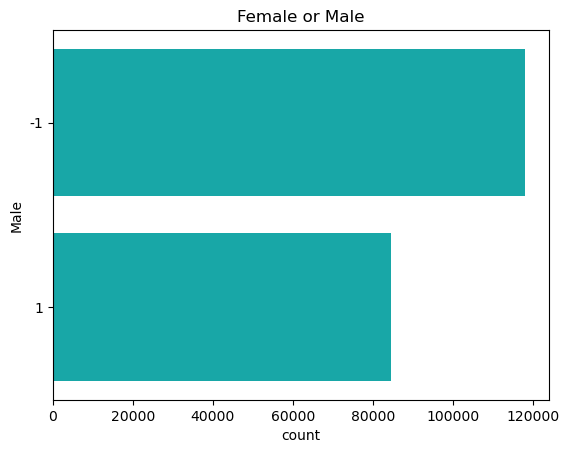

In [5]:
# Plot counts of Female and Male
plt.title('Female or Male')
sns.countplot(y='Male', data=data, color="c")
plt.show()

In [6]:
filenames = data.index 
male = list(data['Male'])
index = range(len(male))

In [7]:
df = pd.DataFrame({'filenames':filenames,'male':male},index=index)

In [8]:
male_rows = df[df['male'] == 1]
female_rows = df[df['male'] == -1]

In [9]:
male_sample = list(male_rows.sample(n=10000,random_state=7).filenames)
female_sample = list(female_rows.sample(n=10000,random_state=7).filenames)

##Extracting Images from Zip file
#import zipfile
#zf = zipfile.ZipFile("img_align_celeba.zip")
#zf.extractall('img_align_celeba')

#Creating Directories for male and female images to be differentiated
source = './img_align_celeba/img_align_celeba/'
os.mkdir('working_sample/')
os.mkdir('working_sample/male_sample')
os.mkdir('working_sample/male_sample/img_align_celeba')
os.mkdir('working_sample/female_sample')
os.mkdir('working_sample/female_sample/img_align_celeba')

#split the images based on Male column fetched from list_attr_celeba.txt file
target = 'working_sample/male_sample/img_align_celeba/'
for filename in male_sample:
    shutil.copy(source+filename,target+filename)
target = 'working_sample/female_sample/img_align_celeba/'
for filename in female_sample:
    shutil.copy(source+filename,target+filename)

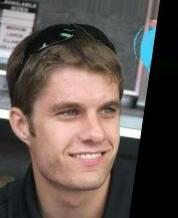

In [11]:
image_male = read_image("working_sample/male_sample/img_align_celeba/026579.jpg")
transforms.ToPILImage()(image_male)

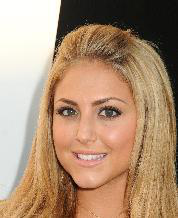

In [12]:
image_female = read_image("working_sample/female_sample/img_align_celeba/014538.jpg")
transforms.ToPILImage()(image_female)

# Data Modelling

In [13]:
#Initial Parameters for building the model

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Batch size during training
batch_size = 8

# Number of workers for dataloader
workers = 2

# Number of training epochs
n_epochs = 2

# Learning rate for optimizers
lr = 0.1

# Momentum for optimizers
momentum = 0.8

# Number of output channels
noOfOutputChannels = 5

# Size of the Kernel
kernel_size = 2

In [14]:
# create male dataset
dataroot = "./working_sample/male_sample"

dataset_male = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
dataset_male.samples = [(image, 1) if label == 0 else (image, label) for image, label in dataset_male.samples]
dataset_male

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: ./working_sample/male_sample
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [15]:
# create female dataset
dataroot = "./working_sample/female_sample"

dataset_female = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
dataset_female

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: ./working_sample/female_sample
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [16]:
# Create train and test datasets
train_size = int(0.8 * len(dataset_male))
test_size = len(dataset_male) - train_size
train_dataset_male, test_dataset_male = torch.utils.data.random_split(dataset_male, [train_size, test_size])
train_dataset_female, test_dataset_female = torch.utils.data.random_split(dataset_female, [train_size, test_size])
train_dataset = torch.utils.data.ConcatDataset([train_dataset_male,train_dataset_female])
test_dataset = torch.utils.data.ConcatDataset([test_dataset_male,test_dataset_female])

In [17]:
# Create the dataloader for train and test datasets enabling the shuffle
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=workers)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=True, num_workers=workers)

In [18]:
class myCNN(nn.Module):
    def __init__(self, noOfOutChannels, kernelSize, activationFunction1, activationFunction2):
        super(myCNN,self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels= noOfOutChannels, kernel_size= kernelSize), 
                                   activationFunction1,nn.MaxPool2d(kernel_size=kernelSize))
        size = (64 - kernelSize + 1)//kernelSize
        new_input_size = noOfOutChannels*size*size
        self.fc = nn.Sequential(nn.Linear(new_input_size,new_input_size//2), activationFunction2)
        self.out = nn.Linear(new_input_size//2,2)
        
    def forward(self,x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.out(x)
        return x

In [19]:
# Train the model
def train(num_epochs, model, loaders):
    model.train()
    total_step = 0
    correct = 0
    for i, (images, labels) in enumerate(loaders):
        total_step += len(labels)
        output = model(images)
        preds = torch.max(output, 1)
        loss = loss_func(output, labels)
        # clear gradients for this training step   
        optimizer.zero_grad()           
        # backpropagation, compute gradients 
        loss.backward()    
        # apply gradients             
        optimizer.step()
        correct += (preds[1]==labels).sum().item()
    train_acc = round(correct*100/total_step,2)
    print(f'Train Accuracy for epoch {epoch+1}: %.2f' % train_acc,'%')
    return train_acc

In [20]:
# Test the model
def test(model,loaders):
    model.eval()
    with torch.no_grad():
        correct = 0
        total_step = 0
        for images, labels in loaders:
            total_step += len(labels)
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            correct += (pred_y == labels).sum().item()
        test_acc = round(correct * 100 / total_step,2)
        cf_matrix = confusion_matrix(labels, pred_y)
        print(f'Test Accuracy for epoch {epoch+1}: %.2f' % test_acc,'%')
    return test_acc        

# Initial Model Validation

In [21]:
model = myCNN(noOfOutputChannels,kernel_size,nn.ReLU(),nn.ReLU())
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)
trainAccuracy=list()
testAccuracy=list()
for epoch in range(n_epochs):
    trainAccuracy.append(train(epoch, model, train_dataloader))
    testAccuracy.append(test(model,test_dataloader))
initial_test_accuracy = testAccuracy[-1]

Train Accuracy for epoch 1: 50.29 %
Test Accuracy for epoch 1: 50.00 %
Train Accuracy for epoch 2: 49.52 %
Test Accuracy for epoch 2: 50.00 %


In [22]:
summary(model,input_size = (3, 64, 64),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [8, 5, 63, 63]              65
              ReLU-2             [8, 5, 63, 63]               0
         MaxPool2d-3             [8, 5, 31, 31]               0
            Linear-4                  [8, 2402]      11,544,012
              ReLU-5                  [8, 2402]               0
            Linear-6                     [8, 2]           4,806
Total params: 11,548,883
Trainable params: 11,548,883
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 3.01
Params size (MB): 44.06
Estimated Total Size (MB): 47.44
----------------------------------------------------------------


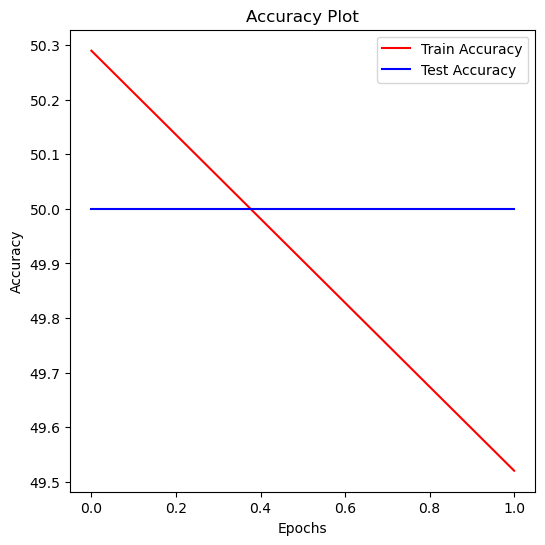

In [23]:
fig = figure(figure(figsize=(6,6)))
plt.plot(trainAccuracy,'r',label = 'Train Accuracy')
plt.plot(testAccuracy,'b',label = 'Test Accuracy')
plt.title("Accuracy Plot")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
legend()

# Hyperparameter Tuning

For performing hyperparameter tuning we have adjusted below parameters to optimize the model and increase the accuracy.
1. Batch Size
2. Kernel Size
3. Learning rate
4. Momentum
5. Optimizer
6. Epochs

Choosing Optimal Batch Size

**** Model Information for Batch Size 16 ****
Train Accuracy for epoch 1: 69.30 %
Test Accuracy for epoch 1: 84.17 %
Train Accuracy for epoch 2: 83.98 %
Test Accuracy for epoch 2: 87.08 %
**** Model Information for Batch Size 32 ****
Train Accuracy for epoch 1: 72.66 %
Test Accuracy for epoch 1: 85.83 %
Train Accuracy for epoch 2: 86.79 %
Test Accuracy for epoch 2: 88.70 %
**** Model Information for Batch Size 64 ****
Train Accuracy for epoch 1: 73.17 %
Test Accuracy for epoch 1: 89.25 %
Train Accuracy for epoch 2: 89.76 %
Test Accuracy for epoch 2: 88.15 %


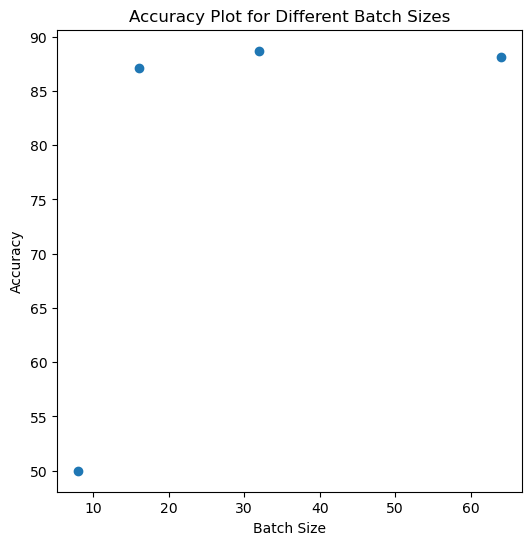

In [24]:
batchsize = [8,16,32,64]
batch_accuracy = [initial_test_accuracy]

#Initial model validation is done with batch size 8
#So we are not re-running for 8 and its accuracy is appended to the accuracy list

for bs in batchsize[1:]:
    print(f'**** Model Information for Batch Size {bs} ****')
    train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=bs, shuffle=True, num_workers=workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=bs, shuffle=True, num_workers=workers)

    #Model
    model = myCNN(noOfOutputChannels,kernel_size,nn.ReLU(),nn.ReLU())
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)
    trainAccuracy=list()
    testAccuracy=list()
    for epoch in range(n_epochs):
        trainAccuracy.append(train(epoch, model, train_dataloader))
        testAccuracy.append(test(model,test_dataloader))
    batch_accuracy.append(testAccuracy[-1])
fig = figure(figure(figsize=(6,6)))
plt.scatter(batchsize,batch_accuracy)
plt.title("Accuracy Plot for Different Batch Sizes")
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.show()

In [25]:
batch_size = batchsize[batch_accuracy.index(max(batch_accuracy))]
# Create dataloader based on optimal batch size
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True, num_workers=workers)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=True, num_workers=workers)
print(f'Optimum Batch Size for this Dataset is : {batch_size}')

Optimum Batch Size for this Dataset is : 32


Choosing Optimal Kernel Size

**** Model Information for Kernel Size 3 ****
Train Accuracy for epoch 1: 82.37 %
Test Accuracy for epoch 1: 88.72 %
Train Accuracy for epoch 2: 89.81 %
Test Accuracy for epoch 2: 90.97 %
**** Model Information for Kernel Size 4 ****
Train Accuracy for epoch 1: 84.14 %
Test Accuracy for epoch 1: 89.33 %
Train Accuracy for epoch 2: 90.06 %
Test Accuracy for epoch 2: 89.70 %
**** Model Information for Kernel Size 5 ****
Train Accuracy for epoch 1: 83.38 %
Test Accuracy for epoch 1: 89.25 %
Train Accuracy for epoch 2: 90.28 %
Test Accuracy for epoch 2: 88.35 %


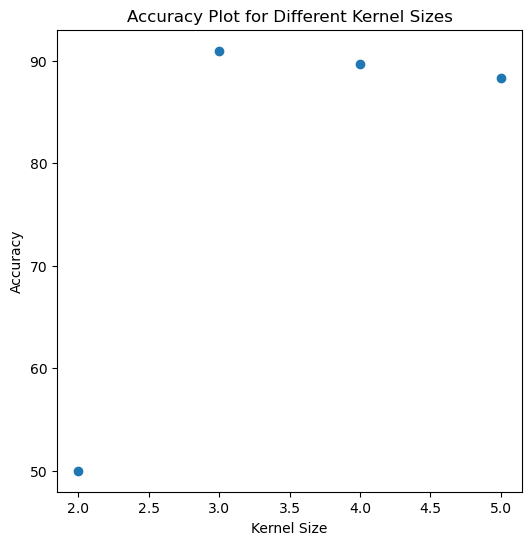

In [26]:
kernelsize = [2,3,4,5]
kernel_accuracy = [initial_test_accuracy]
for ks in kernelsize[1:]:
    print(f'**** Model Information for Kernel Size {ks} ****')
    model = myCNN(noOfOutputChannels,ks,nn.ReLU(),nn.ReLU())
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)
    trainAccuracy=list()
    testAccuracy=list()
    for epoch in range(n_epochs):
        trainAccuracy.append(train(epoch, model, train_dataloader))
        testAccuracy.append(test(model,test_dataloader))
    kernel_accuracy.append(testAccuracy[-1])
fig = figure(figure(figsize=(6,6)))
plt.scatter(kernelsize,kernel_accuracy)
plt.title("Accuracy Plot for Different Kernel Sizes")
plt.xlabel('Kernel Size')
plt.ylabel('Accuracy')
plt.show()

We can observe that the Kernel Size 5 performs better than others, so we use kernel size as 5 for further steps, limiting it to 5 considerning the execution time and workload.

In [27]:
kernel_size = kernelsize[kernel_accuracy.index(max(kernel_accuracy))]
print(f'Optimum Kernel Size for this Dataset is : {kernel_size}')

Optimum Kernel Size for this Dataset is : 3


Choosing Optimal Learning Rate

**** Model Information for Learning Rate 0.01 ****
Train Accuracy for epoch 1: 80.01 %
Test Accuracy for epoch 1: 89.25 %
Train Accuracy for epoch 2: 91.09 %
Test Accuracy for epoch 2: 90.80 %
**** Model Information for Learning Rate 0.001 ****
Train Accuracy for epoch 1: 63.44 %
Test Accuracy for epoch 1: 71.03 %
Train Accuracy for epoch 2: 75.54 %
Test Accuracy for epoch 2: 78.28 %
**** Model Information for Learning Rate 0.0001 ****
Train Accuracy for epoch 1: 50.96 %
Test Accuracy for epoch 1: 57.08 %
Train Accuracy for epoch 2: 63.13 %
Test Accuracy for epoch 2: 65.65 %


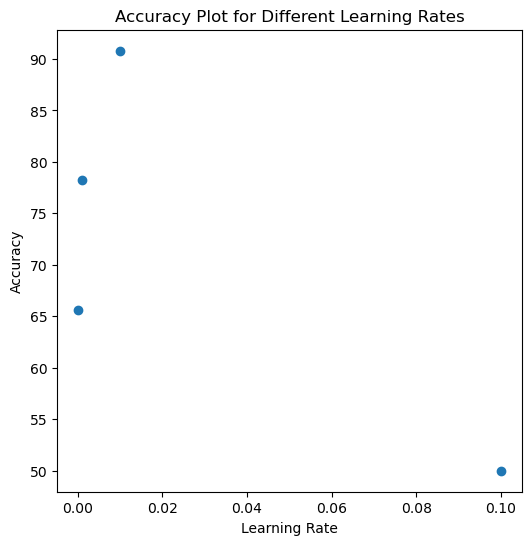

In [28]:
learning_rate = [0.1,0.01,0.001,0.0001]
lr_accuracy = [initial_test_accuracy]
for lr in learning_rate[1:]:
    print(f'**** Model Information for Learning Rate {lr} ****')
    model = myCNN(noOfOutputChannels,ks,nn.ReLU(),nn.ReLU())
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)
    trainAccuracy=list()
    testAccuracy=list()
    for epoch in range(n_epochs):
        trainAccuracy.append(train(epoch, model, train_dataloader))
        testAccuracy.append(test(model,test_dataloader))
    lr_accuracy.append(testAccuracy[-1])
fig = figure(figure(figsize=(6,6)))
plt.scatter(learning_rate,lr_accuracy)
plt.title("Accuracy Plot for Different Learning Rates")
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.show()

In [29]:
lr = learning_rate[lr_accuracy.index(max(lr_accuracy))]
print(f'Optimum Learning Rate for this Dataset is : {lr}')

Optimum Learning Rate for this Dataset is : 0.01


Choosing Optimal Momentum

**** Model Information for Momentum 0.6 ****
Train Accuracy for epoch 1: 74.00 %
Test Accuracy for epoch 1: 86.50 %
Train Accuracy for epoch 2: 89.49 %
Test Accuracy for epoch 2: 91.78 %
**** Model Information for Momentum 0.4 ****
Train Accuracy for epoch 1: 75.69 %
Test Accuracy for epoch 1: 86.15 %
Train Accuracy for epoch 2: 89.02 %
Test Accuracy for epoch 2: 90.80 %
**** Model Information for Momentum 0.2 ****
Train Accuracy for epoch 1: 73.85 %
Test Accuracy for epoch 1: 83.83 %
Train Accuracy for epoch 2: 87.91 %
Test Accuracy for epoch 2: 85.67 %


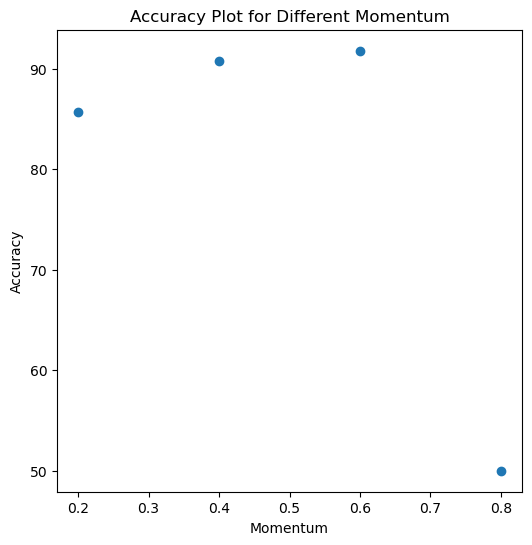

In [30]:
momentums = [0.8,0.6,0.4,0.2]
momentum_accuracy = [initial_test_accuracy]
for momentum in momentums[1:]:
    print(f'**** Model Information for Momentum {momentum} ****')
    model = myCNN(noOfOutputChannels,ks,nn.ReLU(),nn.ReLU())
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)
    trainAccuracy=list()
    testAccuracy=list()
    for epoch in range(n_epochs):
        trainAccuracy.append(train(epoch, model, train_dataloader))
        testAccuracy.append(test(model,test_dataloader))
    momentum_accuracy.append(testAccuracy[-1])
fig = figure(figure(figsize=(6,6)))
plt.scatter(momentums,momentum_accuracy)
plt.title("Accuracy Plot for Different Momentum")
plt.xlabel('Momentum')
plt.ylabel('Accuracy')
plt.show()

In [31]:
momentum = momentums[momentum_accuracy.index(max(momentum_accuracy))]
print(f'Optimum Momentum for this Dataset is : {momentum}')

Optimum Momentum for this Dataset is : 0.6


Choosing best Optimizer function

In [32]:
# SGD Optimizer with optimal learning rate and momentum
model = myCNN(noOfOutputChannels,kernel_size,nn.ReLU(),nn.ReLU())
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)
trainAccuracy=list()
testAccuracy=list()
for epoch in range(n_epochs):
    trainAccuracy.append(train(epoch, model, train_dataloader))
    testAccuracy.append(test(model,test_dataloader))
sgd_accuracy = testAccuracy[-1]

Train Accuracy for epoch 1: 75.84 %
Test Accuracy for epoch 1: 83.70 %
Train Accuracy for epoch 2: 88.79 %
Test Accuracy for epoch 2: 91.53 %


In [33]:
# Adam Optimizer with optimal learning rate
model = myCNN(noOfOutputChannels,kernel_size,nn.ReLU(),nn.ReLU())
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
trainAccuracy=list()
testAccuracy=list()
for epoch in range(n_epochs):
    trainAccuracy.append(train(epoch, model, train_dataloader))
    testAccuracy.append(test(model,test_dataloader))
adam_accuracy = testAccuracy[-1]

Train Accuracy for epoch 1: 82.80 %
Test Accuracy for epoch 1: 89.85 %
Train Accuracy for epoch 2: 92.35 %
Test Accuracy for epoch 2: 91.92 %


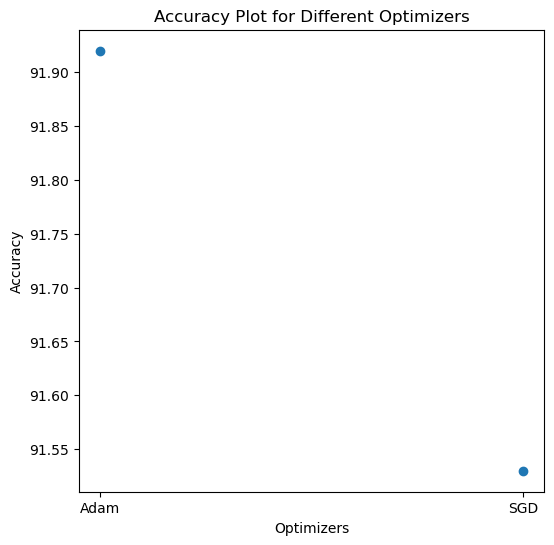

In [37]:
fig = figure(figure(figsize=(6,6)))
plt.scatter(['Adam','SGD'],[adam_accuracy,sgd_accuracy])
plt.title("Accuracy Plot for Different Optimizers")
plt.xlabel('Optimizers')
plt.ylabel('Accuracy')
plt.show()

Choosing number of epochs

**** Model Information for 3 Epoch ****
Train Accuracy for epoch 1: 81.72 %
Test Accuracy for epoch 1: 87.88 %
Train Accuracy for epoch 2: 90.84 %
Test Accuracy for epoch 2: 91.10 %
Train Accuracy for epoch 3: 91.99 %
Test Accuracy for epoch 3: 92.50 %
**** Model Information for 5 Epoch ****
Train Accuracy for epoch 1: 83.56 %
Test Accuracy for epoch 1: 88.05 %
Train Accuracy for epoch 2: 90.74 %
Test Accuracy for epoch 2: 91.55 %
Train Accuracy for epoch 3: 91.73 %
Test Accuracy for epoch 3: 90.88 %
Train Accuracy for epoch 4: 92.24 %
Test Accuracy for epoch 4: 91.83 %
Train Accuracy for epoch 5: 92.72 %
Test Accuracy for epoch 5: 92.10 %
**** Model Information for 10 Epoch ****
Train Accuracy for epoch 1: 82.86 %
Test Accuracy for epoch 1: 90.03 %
Train Accuracy for epoch 2: 91.27 %
Test Accuracy for epoch 2: 88.65 %
Train Accuracy for epoch 3: 92.03 %
Test Accuracy for epoch 3: 89.65 %
Train Accuracy for epoch 4: 92.71 %
Test Accuracy for epoch 4: 92.22 %
Train Accuracy for epoch 5:

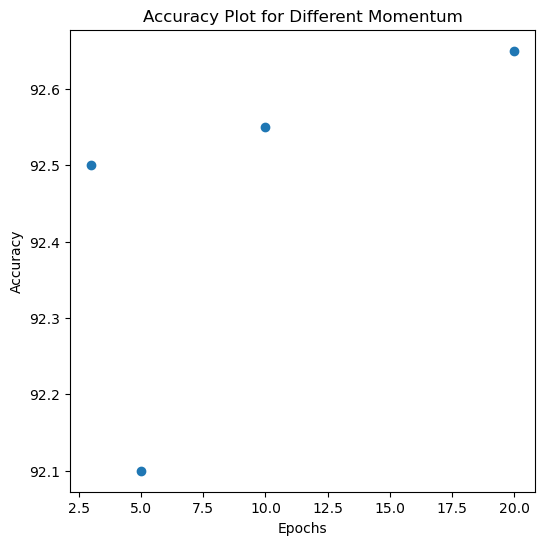

In [35]:
epochs = [3,5,10,20]
epoch_accuracy = []
for e in epochs:
    print(f'**** Model Information for {e} Epoch ****')
    model = myCNN(noOfOutputChannels,ks,nn.ReLU(),nn.ReLU())
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    trainAccuracy=list()
    testAccuracy=list()
    for epoch in range(e):
        trainAccuracy.append(train(epoch, model, train_dataloader))
        testAccuracy.append(test(model,test_dataloader))
    epoch_accuracy.append(testAccuracy[-1])

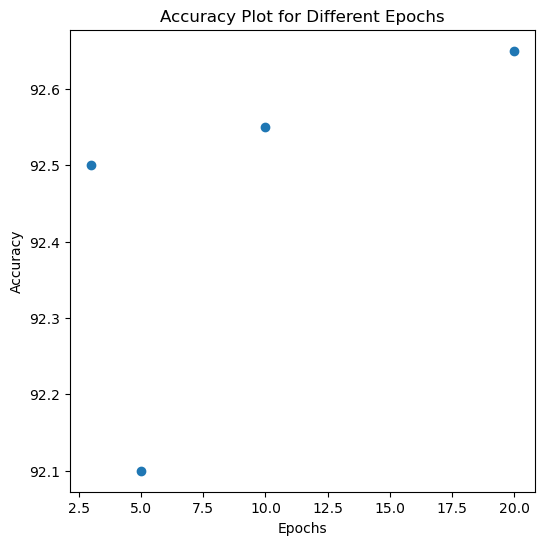

In [38]:
fig = figure(figure(figsize=(6,6)))
plt.scatter(epochs,epoch_accuracy)
plt.title("Accuracy Plot for Different Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [39]:
summary(model,input_size = (3, 64, 64),batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [32, 5, 60, 60]             380
              ReLU-2            [32, 5, 60, 60]               0
         MaxPool2d-3            [32, 5, 12, 12]               0
            Linear-4                  [32, 360]         259,560
              ReLU-5                  [32, 360]               0
            Linear-6                    [32, 2]             722
Total params: 260,662
Trainable params: 260,662
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.50
Forward/backward pass size (MB): 9.14
Params size (MB): 0.99
Estimated Total Size (MB): 11.64
----------------------------------------------------------------
